# Business Problem
 
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business goal.

To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

In [103]:
#importing libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [104]:
#loading the dataset
data = pd.read_csv("telecom_churn_data.csv")
data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [105]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [106]:
data.shape

(99999, 226)

In [107]:
# Calculate the 70th percentile of the average revenue for months 6 and 7
#finding the total amount spent by users on data recharge
data['total_rech_data_amt_6'] = data['av_rech_amt_data_6'] * data['total_rech_data_6']
data['total_rech_data_amt_7'] = data['av_rech_amt_data_7'] * data['total_rech_data_7']
data['total_rech_data_amt_8'] = data['av_rech_amt_data_8'] * data['total_rech_data_8']
data['total_rech_data_amt_9'] = data['av_rech_amt_data_9'] * data['total_rech_data_9']

In [108]:
#dropping the av_rech_amt_data and total_rech_data columns
data.drop(['total_rech_data_6','total_rech_data_7','total_rech_data_8','total_rech_data_9',
'av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8','av_rech_amt_data_9'],axis = 1,inplace = True)

In [109]:
# Find the average recharge done in the first two months(June & July), the good phase
data_av_rech = (data['total_rech_amt_6'].fillna(0) + data['total_rech_amt_7'].fillna(0) + data['total_rech_data_amt_6'].fillna(0) 
+ data['total_rech_data_amt_7'].fillna(0))/2

data_av_rech.head()

0    559.0
1    306.0
2    241.5
3    270.0
4    301.0
dtype: float64

In [110]:
#filtering out customers below 70th percentile, finding the high value customers
percentile_70 = np.percentile(data_av_rech,70)
data_hv_cust = data[data_av_rech >= percentile_70]

In [111]:
data_hv_cust.shape

(30001, 222)

In [112]:
# dividing users into churn and non-churn based on month 9 usage
# Calculate the sum for each customer
data_hv_cust['total_usage_sum'] = data_hv_cust['total_ic_mou_9'] + data_hv_cust['total_og_mou_9'] + data_hv_cust['vol_2g_mb_9'] + data_hv_cust['vol_3g_mb_9']
# Create a new column 'churn' based on the condition
data_hv_cust['churn'] = data_hv_cust['total_usage_sum'].apply(lambda x: 'Churn' if x == 0 else 'Non-Churn')

In [113]:
data_hv_cust.shape

(30001, 224)

In [114]:
#dropping columns for usage in month 9 bascially any column with '_9' in it
cols_to_drop = [col for col in data_hv_cust.columns if '_9' in col]
cols_to_drop

['last_date_of_month_9',
 'arpu_9',
 'onnet_mou_9',
 'offnet_mou_9',
 'roam_ic_mou_9',
 'roam_og_mou_9',
 'loc_og_t2t_mou_9',
 'loc_og_t2m_mou_9',
 'loc_og_t2f_mou_9',
 'loc_og_t2c_mou_9',
 'loc_og_mou_9',
 'std_og_t2t_mou_9',
 'std_og_t2m_mou_9',
 'std_og_t2f_mou_9',
 'std_og_t2c_mou_9',
 'std_og_mou_9',
 'isd_og_mou_9',
 'spl_og_mou_9',
 'og_others_9',
 'total_og_mou_9',
 'loc_ic_t2t_mou_9',
 'loc_ic_t2m_mou_9',
 'loc_ic_t2f_mou_9',
 'loc_ic_mou_9',
 'std_ic_t2t_mou_9',
 'std_ic_t2m_mou_9',
 'std_ic_t2f_mou_9',
 'std_ic_t2o_mou_9',
 'std_ic_mou_9',
 'total_ic_mou_9',
 'spl_ic_mou_9',
 'isd_ic_mou_9',
 'ic_others_9',
 'total_rech_num_9',
 'total_rech_amt_9',
 'max_rech_amt_9',
 'date_of_last_rech_9',
 'last_day_rch_amt_9',
 'date_of_last_rech_data_9',
 'max_rech_data_9',
 'count_rech_2g_9',
 'count_rech_3g_9',
 'vol_2g_mb_9',
 'vol_3g_mb_9',
 'arpu_3g_9',
 'arpu_2g_9',
 'night_pck_user_9',
 'monthly_2g_9',
 'sachet_2g_9',
 'monthly_3g_9',
 'sachet_3g_9',
 'fb_user_9',
 'total_rech_dat

In [115]:
data_hv_cust.drop(cols_to_drop,axis=1,inplace=True)

In [116]:
data_hv_cust.shape

(30001, 171)

In [117]:
#dropping variables which have only one unique value
for i in data_hv_cust.columns:
    if data_hv_cust[i].nunique()==1:
        data_hv_cust.drop(i,axis=1,inplace=True)

In [123]:
#checking for null values in dataset, dropping columns which have more than 30 percentage of null values
percentage_missing =(data_hv_cust.isnull().sum()/data_hv_cust.shape[0])*100
threshold = 30
columns_drop = percentage_missing[percentage_missing > threshold].index
data_hv_cust.drop(columns=columns_drop, inplace=True)

In [119]:
data_hv_cust.shape

(30001, 131)

In [120]:
#converting churn columns to 0 and 1
data_hv_cust['churn'] = data_hv_cust['churn'].apply(lambda x: 1 if x == 'Churn' else 0)

In [124]:
percentage_missing.sort_values(ascending = False)

std_ic_t2t_mou_8      3.913203
roam_og_mou_8         3.913203
loc_og_t2c_mou_8      3.913203
std_ic_mou_8          3.913203
isd_og_mou_8          3.913203
                        ...   
max_rech_amt_7        0.000000
max_rech_amt_8        0.000000
last_day_rch_amt_6    0.000000
last_day_rch_amt_7    0.000000
churn                 0.000000
Length: 131, dtype: float64

In [125]:
#dropping rows with missing values
columns_with_missing_values = data_hv_cust.columns[data_hv_cust.isnull().any()].tolist()
data_hv_cust1 = data_hv_cust.dropna(subset=columns_with_missing_values)

In [128]:
# Checking percentage of missing values after removing the missing values
round(100*(data_hv_cust1.isnull().sum()/len(data_hv_cust1.index)), 2)
#all the rows with missing values have been removed

mobile_number      0.0
arpu_6             0.0
arpu_7             0.0
arpu_8             0.0
onnet_mou_6        0.0
                  ... 
jul_vbc_3g         0.0
jun_vbc_3g         0.0
sep_vbc_3g         0.0
total_usage_sum    0.0
churn              0.0
Length: 131, dtype: float64

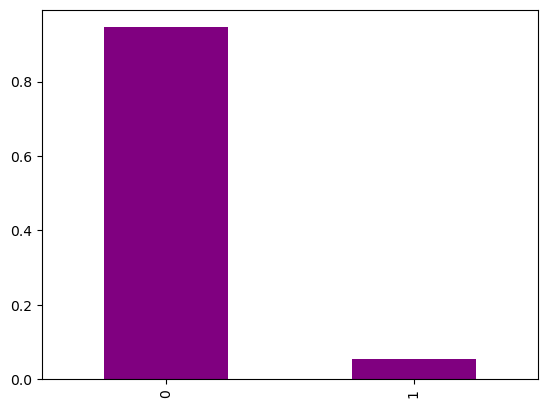

In [131]:
#checking data imbalance in Churn column
data_hv_cust1.churn.value_counts(normalize = True).plot.bar(color='Purple')
plt.show()
#looks like there is data imblance which would need to be handled